# Machine-learning in Python using scikit-learn
## What is scikit-learn
* A comprehensive, concise machine learning (ML) and data-mining (DM) library.
  * Data-set generators.
  * Clustering.
  * Classification / prediction, cross-validation.
  * Dimensionality reduction.
  * Ensemble methods (Boosting, Random Forests).
  * ...
* Open-source, excellent documentation.

In [4]:
from IPython.core.display import Image
Image(url="http://scikit-learn.org/stable/_static/ml_map.png", width=1300)

## Topics
* Installation.
* Building, testing, and quantifying a classifier.
   1. Generating a classifiable dataset.
   2. Training and testing a classifier.
   3. Quantifying classification robustness.
   4. Identifying significant features.

## Installation
scikit-learn requires numerous prerequisite libraries:

* [numpy](http://www.numpy.org/)
* [scipy](http://www.scipy.org/)
* [matplotlib](http://matplotlib.org/index.html).

Though not required, the [pandas](http://pandas.pydata.org/) library is recommended if frequently working for tabular data-handling).

If you wish to have Python distributions with many libraries pre-installed for you (including scikit-learn), [Anaconda Python](http://docs.continuum.io/anaconda/index.html) would be a great choice.

Now, we can begin exploring its capabilities.

In [5]:
import sklearn
print(sklearn.__version__)
print(sklearn.__doc__)

0.14.1

Machine learning module for Python

sklearn is a Python module integrating classical machine
learning algorithms in the tightly-knit world of scientific Python
packages (numpy, scipy, matplotlib).

It aims to provide simple and efficient solutions to learning problems
that are accessible to everybody and reusable in various contexts:
machine-learning as a versatile tool for science and engineering.

See http://scikit-learn.org for complete documentation.



## Building, testing, and quantifying a classifier.

* Suppose you have a matrix derived from experimentation.
* We define column names as **features, attributes** and row names as **observations**.
* We also have experimentation for **negative controls**.
* We create a binary **target vector** that indicates whether the observation is/is not a negative control.
* **Classification enables examination whether our features are more enriched in observations or our control.**


In [6]:
import pandas
import numpy
from sklearn import datasets
x, y = datasets.make_classification(n_samples=5, n_features=6, n_classes=2)
matrix = pandas.DataFrame(data=x, columns=['A', 'B', 'C', 'D', 'E', 'F'])
print matrix  # print results representing observations and controls.

          A         B         C         D         E         F
0  1.115703 -1.012206 -0.892101 -0.854561 -0.675650  0.585359
1  0.100017  1.188556  0.911898 -0.137961  0.725881  1.072707
2 -3.522209  0.634121  0.830426  1.104247  0.558388  0.034511
3 -0.300044 -1.610883 -1.220101 -1.325381 -0.975936  1.715463
4 -2.108464  1.826168  1.618673  1.956304  1.223545 -1.785996

[5 rows x 6 columns]


/Users/hossein2/anaconda/lib/python2.7/site-packages/numexpr/cpuinfo.py:71: UserWarning: [Errno 2] No such file or directory
  stacklevel=stacklevel+1):


In [7]:
target = pandas.DataFrame(data=y, columns=['Target'])
print target  # each observation has a concordant target; 1 if observation, 0 otherwise.

   Target
0       0
1       1
2       0
3       1
4       0

[5 rows x 1 columns]


**Let us now build a much larger matrix for use in our classification initiatives.**

In [15]:
# 20,000 x 20 matrix, therefore 10,000 observations and 10,000 controls.
x, y = datasets.make_classification(n_samples=20000, n_features=20, n_classes=2, n_informative=15)

# contrast distribution of query and control datasets.
print numpy.percentile(x[y == 1 ],  [0, 25, 50, 75, 100])
print numpy.percentile(x[y == 0 ],  [0, 25, 50, 75, 100])

[-22.911947032930588, -1.3214952511974263, 0.12728307477999101, 1.6302426403512671, 19.2247366553683]
[-24.451914993023031, -1.6170484788712298, -0.10327829257433777, 1.3557632972283202, 24.238026749648604]


### Cross-validation
**Classification and prediction go hand-in-hand. Without going into too much detail, finding the best parameters such that predictive error is most minimal is paramount to building a robust classifier. After all, a classifier built using parameters appreciating low error rates is key to sound classification. Deriving such parameters is made possible using cross-validation (CV). We use CV and use its outputs to build a LASSO classifier. Many classifiers exist ([SVM](http://en.wikipedia.org/wiki/Support_vector_machine), [Logistic Regression](http://en.wikipedia.org/wiki/Logistic_regression), [LASSO](http://statweb.stanford.edu/~tibs/lasso.html), etc). **

**Big picture: CV splits a matrix into smaller chunks; one chunk is for training a classifier, the other for testing. Repeating this many times helps produce a classifier trained and tested on different parts of the matrix**

In [9]:
from sklearn import linear_model
from sklearn import cross_validation

# cross-validate our matrix
# n => number of rows; 4/5 of matrix is for training.
cv_object = cross_validation.KFold(n=x.shape[0], n_folds=5, random_state=0)

# per iteration, classifier training is independent of testing.
for i, (train_index, test_index) in enumerate(cv_object):
    print 'Iteration', i+1
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print '  training, testing sizes:', x_train.shape[0], x_test.shape[0]
    print '  training, testing medians:', numpy.median(x_train), numpy.median(x_test), '\n'

Iteration 1
  training, testing sizes: 16000 4000
  training, testing medians: -0.0116628184917 -0.00707937745853 

Iteration 2
  training, testing sizes: 16000 4000
  training, testing medians: -0.00918881000673 -0.0164140121966 

Iteration 3
  training, testing sizes: 16000 4000
  training, testing medians: -0.00894023391386 -0.0165946824802 

Iteration 4
  training, testing sizes: 16000 4000
  training, testing medians: -0.0125886460733 -0.00534676343965 

Iteration 5
  training, testing sizes: 16000 4000
  training, testing medians: -0.0113567367599 -0.00866053853834 



**Without CV, you would be training and testing on the same data; skewing results (overfitting). Upon completion of such iterations, you can extract parameters that minimize predictive error; critical to maximizing predictive robustness. Let us now use CV to identify such parameters.**

In [10]:
# CV aims to find optimal parameters which decrease predictive error.
# Such a parameter, alpha (or lambda) is produced following CV.
alphas = []

cv_object = cross_validation.KFold(n=x.shape[0], n_folds=5, random_state=0)
for i, (train_index, test_index) in enumerate(cv_object):
    print 'Iteration', i+1
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    classifier = linear_model.LassoCV(cv=5) 
    classifier.fit(x_train, y_train)  # train a classifier
    predictions = classifier.predict(x_test) # test the classifier
    alphas.append(classifier.alpha_)
    print classifier.alpha_, '\n'

Iteration 1
0.00198635289332 

Iteration 2
0.00214969098504 

Iteration 3
0.00230751343542 

Iteration 4
0.000613111083138 

Iteration 5
0.00124810355586 



/Users/hossein2/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:418: UserWarning: Objective did not converge. You might want to increase the number of iterations
  ' to increase the number of iterations')


**You can quantify predictive robustness by enumerating false-positive and true-positive predictions, visualized using a Receiver Operating Characteistic (ROC) curve.**

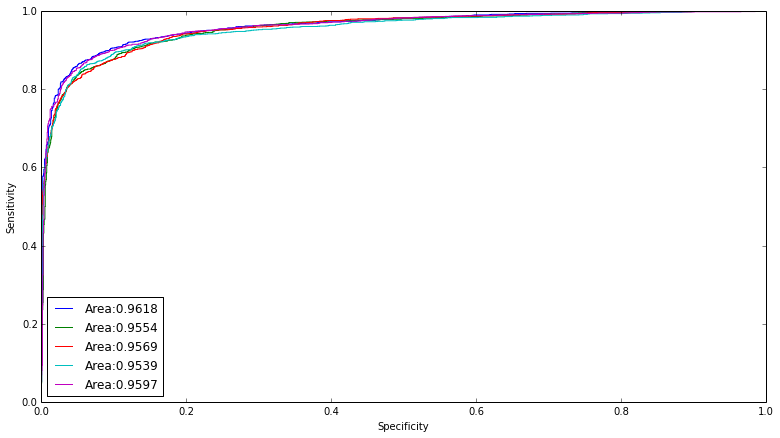

In [14]:
from sklearn import metrics
from matplotlib import pyplot

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (13.0, 7.0)  # image size

for i, (train_index, test_index) in enumerate(cv_object):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    classifier = linear_model.LassoCV(cv=5) 
    classifier.fit(x_train, y_train)  # train a classifier
    predictions = classifier.predict(x_test) # test the classifier
    
    # let us compute a false-positive rate (FPR) and true-positive rate(TPR) given our predictions, 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    auc = round(metrics.auc(fpr, tpr), 4)
    pyplot.plot(fpr, tpr, label='Area:' + str(auc))

pyplot.xlabel('False Positive Rate')  # measures FPR
pyplot.ylabel('True Positive Rate')  # measures TPR
pyplot.legend(loc="lower left")
pyplot.show()

**As we can see, there are numerous classifiers; each performing very well. One classifier, however, yields parameters that maximize predictive robustness. CV enables identification of this parameter, alpha (or lambda)**

In [12]:
best_alpha = numpy.median(alphas)  # we choose the median alpha.

# we can now build a classifier given the original matrix and its target.
classifier = linear_model.Lasso(alpha=best_alpha)
classifier.fit(x, y)

# features classified in group 1 (observations) will have positive weight.
results = pandas.DataFrame()
results['Weights'] = classifier.coef_
print results

     Weights
0   0.026836
1   0.039007
2   0.038161
3  -0.016444
4  -0.039198
5   0.008296
6   0.012845
7   0.019527
8  -0.027632
9  -0.000000
10  0.008639
11  0.058691
12  0.007749
13 -0.000000
14  0.000000
15 -0.000549
16 -0.041223
17 -0.043183
18  0.000232
19  0.022041

[20 rows x 1 columns]


### Conclusions
**We built a binary classifier for a randomly-generated dataset. Using the LASSO classification algorithm and cross-validation, we trained numerous classifier and chose an optimal parameter, alpha, to decrease predictive error-rates.**

### What we left out
* Homogenization: Removing observations that have properties similar to controls.
* Feature selection: Namely boosting and random forests.
* Multi-nomial targets: Instances whereby your target is not binary.